In [1]:
import os
os.chdir("../../")

import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go


In [2]:
# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size = 1000):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 4, 0.25)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model, pop_size = 1000):
    G = init_graph(initial_infection, graph_model, pop_size)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update({'status' : 'infected',
                                  'infection_day': 0, 
                                  'contacts_infected': 0})
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})



def recover_one_step(G, day, recover_time = 12):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'infected':
            if np.random.random() < 1/15:
                G.nodes[node]['status'] = 'recovered'
            #if day - G.nodes[node]['infection_day'] >= recover_time: 
            #    G.nodes[node]['status'] = 'recovered'

def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    for node in np.unique(newly_infected):
        G.nodes[node].update({'status' : 'infected', 'infection_day': day})
        
    return len(newly_infected)


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result
    
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, 
                          lambda_leak=.05, graph_model = 'relaxed_caveman', pop_size = 1000):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    G, data, status, pop = init_parameters(initial_infection, graph_model, pop_size)

    day = 0
    #while status['infected']>(.00001*pop) and  (status['recovered']+status['susceptible'])<pop:
    while (status['recovered']+status['susceptible'])<pop:
    
        day +=1
        
        recover_one_step(G, day, recover_time)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        status = current_status(G)
        i = status['infected'] / pop
        s = status['susceptible'] / pop
        r = status['recovered'] / pop
        
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True) if node['status'] == 'recovered']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
        data.append([s, i, r, newly_infected, contacts_infected])
    columns = ['susceptible', 'infected', 'recovered', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series


In [ ]:
G = init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size=100)
plot_graph(G)

In [9]:
G = init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size=100)

fig = go.Figure(go.Histogram(x=[deg for n, deg in G.degree()], histnorm='probability'))
fig.update_layout(title_text='Histogram of Connections per Node - Relaxed Caveman',
                  xaxis_title_text='Connections', # xaxis label
                  yaxis_title_text='Probability', # xaxis label

                 )
fig.show()
fig.write_image('relaxed_caveman.png', format='png', scale=3)

In [ ]:
#hist = sns.distplot([deg for n, deg in G.degree()], kde=False)
#hist.set_xticks(range(1,6))


counts = pd.Series([deg for n, deg in G.degree()]).value_counts()

fig = go.Figure(go.Bar(x=counts.index.to_list(), y=counts.values))
fig.update_layout(title_text='Average Connections per Node')
fig.
fig.show()


In [8]:
G = init_graph(initial_infection = .05, graph_model = 'scale_free', pop_size=100)
plot_graph(G)

In [10]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is E6E0-67EF

 Directory of C:\Users\GuilhermeYambanisTho\Desktop

05/06/2020  03:40 PM    <DIR>          .
05/06/2020  03:40 PM    <DIR>          ..
05/05/2020  04:45 PM    <DIR>          .ipynb_checkpoints
04/28/2020  04:46 PM    <DIR>          Backup
05/05/2020  04:13 PM            52,998 Capture.PNG
05/06/2020  12:01 PM               128 conversa_tcc_6-5.txt
05/04/2020  10:55 PM            56,926 Cronograma SLB.pptx
04/29/2020  10:26 AM        13,187,535 Dados MHR  Salobo 29-04-2020.zip
05/04/2020  02:17 PM             1,930 ex7.sql
04/27/2020  02:06 PM    <DIR>          Geometal%20Analytics
04/27/2020  09:03 AM    <DIR>          IME
04/28/2020  06:24 PM    <DIR>          MHR
04/30/2020  09:01 AM           575,568 MHR - Discussao de Modelo.pptx
04/28/2020  11:26 AM             4,697 model.py
04/27/2020  10:47 PM               453 newly_infected = [].py
05/06/2020  03:39 PM           125,982 relaxed_caveman.png
05/06/2020  03:40 PM

In [ ]:
G = init_graph(initial_infection = .05, graph_model = 'scale_free', pop_size=100)


#counts = pd.Series([deg for n, deg in G.degree()]).value_counts()

fig = go.Figure(go.Histogram(x=[deg for n, deg in G.degree()], 
                             histnorm='probability', xbins={'size':1}))
fig.update_layout(title_text='Histogram of Connections per Node - Scale Free',
                  xaxis_title_text='Connections', # xaxis label
                  yaxis_title_text='Probability', # xaxis label

                 )
fig.write_image('scale_free_hist.png', format='png', scale=3)
fig.show()


In [ ]:
!dir

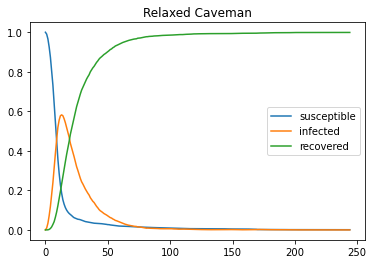

In [15]:
time_series = simulate_pandemic(p_r = 0.5, lambda_leak=.01, pop_size=5000, 
                                initial_infection = 1/5000)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'], label = 'infected')
plt.plot(time_series.index, time_series['recovered'], label = 'recovered')
plt.legend()
plt.title('Relaxed Caveman')
plt.savefig('relaxed_caveman_simulation.png', fromat='png', dpi = 300)
plt.show()

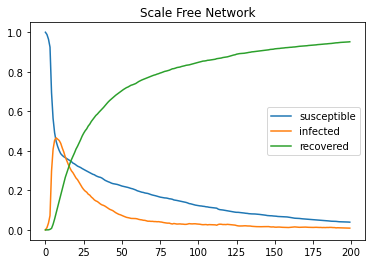

In [17]:
time_series = simulate_pandemic(graph_model='scale_free', p_r = .5, lambda_leak=.01, 
                                 pop_size  = 5000, initial_infection = 1/5000)

plt.plot(time_series.index[:200], time_series['susceptible'][:200], label = 'susceptible')
plt.plot(time_series.index[:200], time_series['infected'][:200], label = 'infected')
plt.plot(time_series.index[:200], time_series['recovered'][:200], label = 'recovered')
plt.legend()
plt.title('Scale Free Network')
plt.savefig('scale_free_simulation.png', format='png', dpi = 300)
plt.show()

In [ ]:
def get_beta_and_gamma(time_series):
    """
    
    """
    def gamma_t(current_t, next_t): 
        return (next_t['recovered'] - current_t['recovered'])/current_t['infected']
    
    def beta_t(current_t, next_t):
        return (next_t['infected']-current_t['infected']+next_t['recovered']-current_t['recovered'])/current_t['infected']
    
    tmp = pd.concat([time_series, time_series.shift(-1)], axis=1)
    
    time_series['gamma'] = tmp.apply(lambda x: gamma_t(x[:int(len(x)/2)], x[int(len(x)/2):]), axis=1)
    time_series['beta'] = tmp.apply(lambda x: beta_t(x[:int(len(x)/2)], x[int(len(x)/2):]), axis=1)
    
    return time_series

In [ ]:
df = get_beta_and_gamma(time_series)

In [ ]:
df['R0_t'] = df['beta'] / df['gamma']

In [ ]:
df.describe()

In [ ]:
df.describe()

In [ ]:
plt.plot(df.index, df['R0_t'])

# Incubation, Onset and Hospitalization periods

## Incubation period

Distribution: LogNormal

Mean: 5.6, SD 2.8

## Onset to Hospitalization

Distribution: Gamma

### Living Cases

Mean: 3.3
SD 4.2

### Deceased Cases

Mean: 6.5
SD: 4.0

## Hospitalization to Death

Distribution: Weibull

Mean: 8.9
SD: 5.4

In [ ]:
from numpy.random import lognormal, weibull
import seaborn as sns

In [ ]:
# INCUBATION PERIOD

mean=5.6
sigma=2.8

log_mean = np.log(mean) - .5*np.log(((sigma/mean)**2)+1)
log_sd = np.sqrt(np.log((sigma/mean)**2 + 1))

incubation = lognormal(mean=log_mean, sigma=log_sd, size=10000)
sns.distplot(incubation)
plt.title('Incubation Period')
plt.show()

In [ ]:
# ONSET TO DEATH

mean=14.5
sigma=6.7

log_mean = np.log(mean) - .5*np.log(((sigma/mean)**2)+1)
log_sd = np.sqrt(np.log((sigma/mean)**2 + 1))

onset_to_death = lognormal(mean=log_mean, sigma=log_sd, size=10000)
sns.distplot(onset_to_death)
plt.title('Onset to Death')
plt.show()

In [ ]:
from scipy import stats

# Onset to Hospitalization - Living

mean = 3.3
sd = 4.2

shape = (mean**2)/(sd**2)
scale = (sd**2)/mean

onset_to_hosp_living = np.random.gamma(shape, scale, 10000)
sns.distplot(onset_to_hosp_living)
plt.title('Onset to Hospitalization - Days (Living)')
plt.show()

In [ ]:
scale

In [ ]:
from scipy import stats
from scipy.special import gamma
import numpy as np
import seaborn as sns


# Onset to Hospitalization - Decesead
mean =  6.5
sd = 0.62
shape = (mean**2)/(sd**2)
scale = (sd**2)/mean

onset_to_hosp_dead = np.random.gamma(shape, scale, 10000)
sns.distplot(onset_to_hosp_dead)
plt.title('Onset to Hospitalization - Days (Deceased)')
plt.show()

In [ ]:
scale

In [ ]:
# Hospitalization to Death

mean = 8.9
sd = 5.4

shape = (sd/mean)**(-1.086)
scale = mean/(gamma(1 + 1/shape))

hosp_to_death = stats.weibull_min.rvs(c = shape, scale=scale, size=100000)
sns.distplot(hosp_to_death)
plt.title('Hospitalization to Death - Days')
plt.show()

In [ ]:
0 -> 6 -> 5
0 -> 4 -> 7


In [ ]:
np.random.random()

In [ ]:
sns.distplot(np.random.gamma(6.5, 0.62, 10000))

In [ ]:
from scipy.stats import gamma

fig, ax = plt.subplots(1, 1)

theta = 1/0.62
a = 6.5

mean, var, skew, kurt = gamma.stats(a, moments='mvsk')
x = np.linspace(0, 20, 100)
ax.plot(x, gamma.pdf(x, a=a, scale=theta, loc=-5),
          'r-', lw=5, alpha=0.6, label='gamma pdf')

In [ ]:
from scipy.stats import gamma

fig, ax = plt.subplots(1, 1)

theta = 0.62
a = 6.5

mean, var, skew, kurt = gamma.stats(a, moments='mvsk')
x = np.linspace(0, 20, 100)
ax.plot(x, gamma.pdf(x, a=a, scale=theta),
          'r-', lw=5, alpha=0.6, label='gamma pdf')

In [ ]:
a*k = 6.5?


6.5 =  a * scale

In [ ]:
mean = 6.5
sd = 0.62

theta = sd/mean
k = mean/theta

sns.distplot(np.random.gamma(k, theta, size = 10000))


In [ ]:
sns.distplot(np.random.gamma(6.5*0.62, 1/0.62, size = 10000))